In [0]:
# from google.colab import files
# uploaded = files.upload()

In [0]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

**Import data from CSV**

In [6]:
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
print("shape of data",candidate_sentences.shape)
candidate_sentences['sentence'].sample(5)

shape of data (4318, 1)


2650    shaggy was set to be a stoner, velma and daphne had a side relationship,  and there were many  marijuana references.
964                                          with film cameras, a roll is usually completely exposed before being processed.
1935                                             early in its history, the nfb was a primarily english-speaking institution.
2755                                                      a cover version of the old work action song u tunelu usred mraka .
1671                                                                       it was founded by the director arzén von cserépy.
Name: sentence, dtype: object

**Extract Node from data (Extract field of Interest)**

In [7]:
#Demo to what is field of interest
doc = nlp("the drawdown process is governed by astm standard d823")
for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


In [0]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""
  prv_tok_text = "" 

  prefix = ""
  modifier = ""
  for tok in nlp(sent):
    if tok.dep_ != "punct":
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  return [ent1.strip(), ent2.strip()]

In [9]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [10]:
#built Node for given data
entity_pairs = []
for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:38<00:00, 112.50it/s]


In [11]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

**Extract relation ship between Sentences**

In [0]:

def get_relation(sent):

  doc = nlp(sent) 
  matcher = Matcher(nlp.vocab)

  #Pattern of relation ship in english sentence
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
  matcher.add("matching_1", None, pattern) 
  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]] 
  return(span.text)

In [13]:
#Example
get_relation("John completed the task")

'completed'

In [14]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]
pd.Series(relations).value_counts()[:50]

100%|██████████| 4318/4318 [00:37<00:00, 116.30it/s]


is               370
was              297
released on       87
include           73
are               71
were              71
released          40
's                38
composed by       35
have              31
has               31
became            31
become            29
released in       27
included          26
called            22
produced          22
had               20
made              20
considered        20
be                18
been              18
scheduled         17
used              17
directed by       16
stars             16
written by        15
set               14
wrote             14
hired             14
produced by       14
went              13
received          13
introduced in     13
wanted            12
began in          11
won               11
began             11
features          10
gave              10
sold              10
produced in        9
directed           9
known as           9
used in            9
reported           9
shot in            9
gives        

In [0]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [0]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

**Plot Graph**

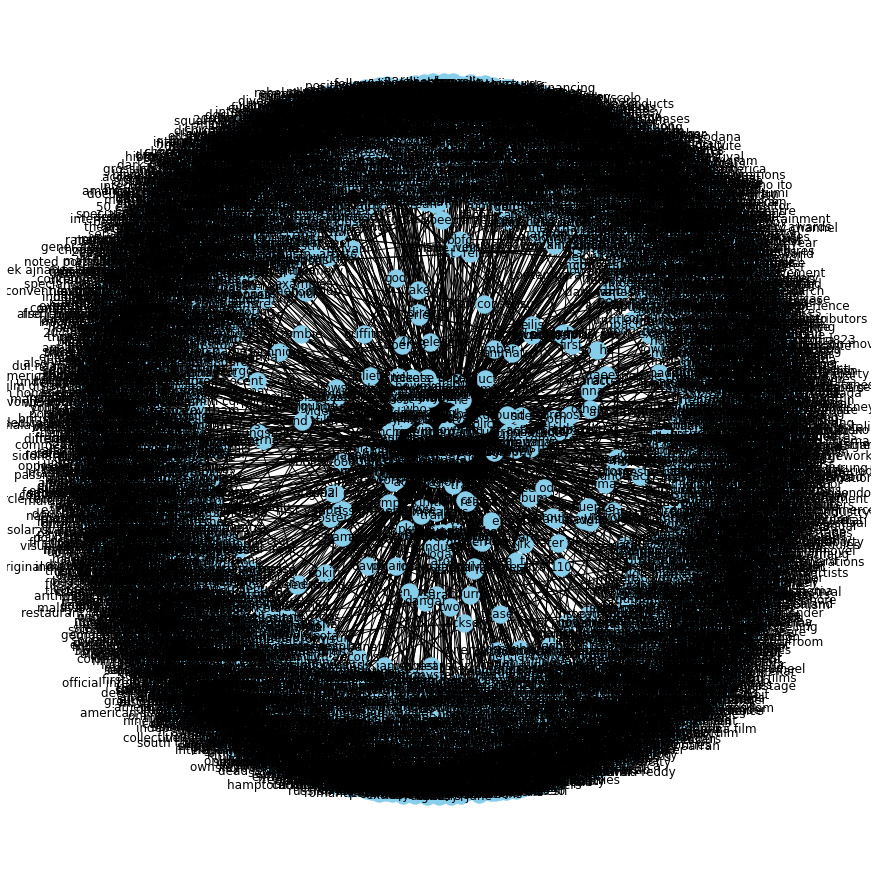

In [17]:

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

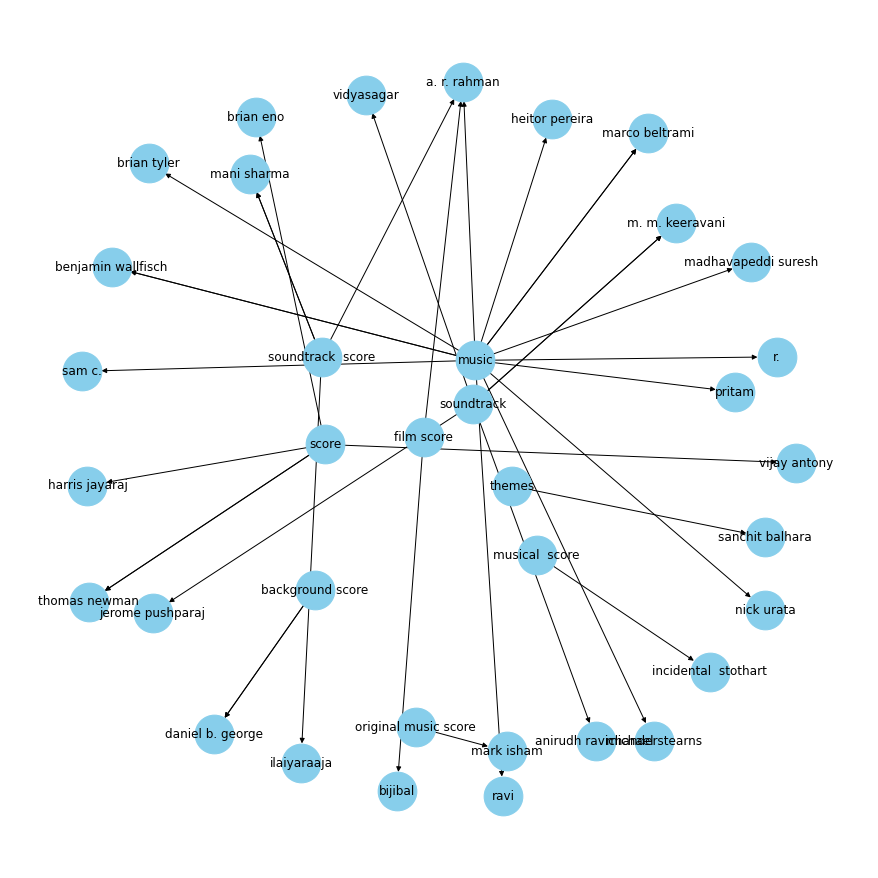

In [18]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

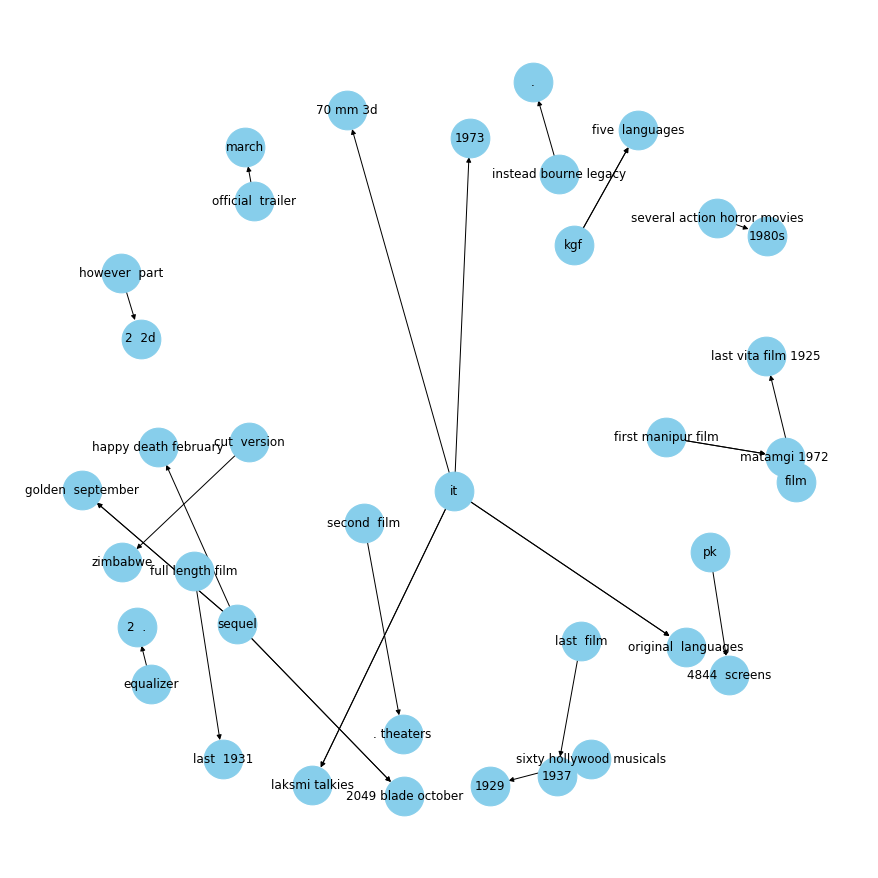

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()